In [310]:
import pandas as pd
import requests
import seaborn as sns
import numpy as np
from requests_file import FileAdapter
from bs4 import BeautifulSoup

I decided to work with a historical dataset: Ships owned by the English East India Company (EIC) throughout its several hundred years of existance.

As far as I know, no prepared dataset of these ships exist. However, the web page eicships.threedecks.org collects records on a large number of EIC ships, which should be sufficient for this assignment. This does mean additional work in scraping the data, as there is no option to download the data in bulk - but this work may  pay off later, as I am considering working on the EIC for my Master's thesis.

Since the website in question uses a PHP search function and I don't know how to deal with that, I have instead downloaded the result page of my search as an HTM page and access this with the requests_file library, which allows using requests on offline files. I have uploaded the HTM page to my repository.

In [327]:
s = requests.Session()
s.mount('file://', FileAdapter())
response = s.get("file:///C:/Users/lorga/Uni/2. Block/Collecting Data/Assignment 5/Ships of the East India Company.htm")
html_string = response.text
html_body = BeautifulSoup(html_string, "html.parser")
rows = html_body.find_all("tr", attrs = {"bgcolor": "#FFF1DF"})
cells = [row.find_all("td") for row in rows]
cell_list = []
for row in cells:
    for cell in row:
        cell_list.append(cell.text.replace("\n", ""))
        
ships_dictionary = {
    "id": [],
    "name": []
}

while cell_list:
    ships_dictionary["id"].append(cell_list[0])
    ships_dictionary["name"].append(cell_list[1])
    cell_list = cell_list[7:]
    
ships = pd.DataFrame(ships_dictionary)

ships

,id,name
0,811,Abberton
1,812,Abercrombie Robinson
2,1261,Abercromby
3,1,Abigail
4,131,Abingdon
...,...,...
1713,1753,Young Nicholas
1714,1752,Young William
1715,420,Zante Frigate
1716,1237,Zenobia


We can now scrape the individual pages for all ships for their full HTML body.

In [103]:
def html_scraper(id):
    response = requests.get("https://eicships.threedecks.org/ships/shipdetail.php?shipID=" + id)
    html_string = response.text
    return html_string
    
ships["html"] = ships["id"].apply(html_scraper)

ships

,id,name,html
0,811,Abberton,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
1,812,Abercrombie Robinson,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
2,1261,Abercromby,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
3,1,Abigail,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
4,131,Abingdon,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
...,...,...,...
1713,1753,Young Nicholas,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
1714,1752,Young William,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
1715,420,Zante Frigate,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
1716,1237,Zenobia,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."


We now need to get the data out of the html bodies. I first tried this with a single function, but could not get the assignment of several new columns at once to work. I've left this attempted function in and would be glad if you could let me know whether there is a way to make this work.

In [164]:
def ship_scraper(html): 
    html_parsed = BeautifulSoup(html, "html.parser")
    table = html_parsed.find("table", attrs={"name": "shipdetails"})
    table_contents = table.find("tr", attrs={"bgcolor": "#FFF1DF"})
    built = table_contents.find("td", attrs={"width": "74"}).text
    ship_type = table_contents.find("td", attrs={"width": "76"}).text
    tons = table_contents.find("td", attrs={"width": "62"}).text
    voyages = table_contents.find("td", attrs={"width": "63"}).text
    service = table_contents.find("td", attrs={"width": "87"}).text
    service_start = service.split("-")[-1]
    service_end = service.split("-")[0]
    return built, ship_type, tons, service_start, service_end, voyages
    
ships[["built", "ship_type", "tons", "service_start", "service_end", "voyages"]] = ships["html"].apply(ship_scraper)
#ships["built"], ships["ship_type"], ships["tons"], ships["service_start"], ships["service_end"], ships["voyages"] = ships["html"].apply(ship_scraper)
#ships.drop(columns = ["html"], inplace = True)
ships

ValueError: Columns must be same length as key

I instead took the unpleasant route of having a function for every new column being added, but did end up with a working dataframe. However, the dataset is extremely unclean, as it relies on scraping over 1700 individual ships' pages. I tried to clean it as much as possible here, but would also be glad about feedback on how to do this cleaning more efficiently for the various columns.

In [311]:
def built_scraper(html): 
    html_parsed = BeautifulSoup(html, "html.parser")
    table = html_parsed.find("table", attrs={"name": "shipdetails"})
    table_contents = table.find("tr", attrs={"bgcolor": "#FFF1DF"})
    built = table_contents.find("td", attrs={"width": "74"}).text
    if len(built) > 4:
        built = built.split(" ")[2]
    return built

def ship_type_scraper(html): 
    html_parsed = BeautifulSoup(html, "html.parser")
    table = html_parsed.find("table", attrs={"name": "shipdetails"})
    table_contents = table.find("tr", attrs={"bgcolor": "#FFF1DF"})
    ship_type = table_contents.find("td", attrs={"width": "76"}).text
    if len(ship_type) > 4:
        ship_type = ship_type.split(" ")[2]
    return ship_type

def tons_scraper(html): 
    html_parsed = BeautifulSoup(html, "html.parser")
    table = html_parsed.find("table", attrs={"name": "shipdetails"})
    table_contents = table.find("tr", attrs={"bgcolor": "#FFF1DF"})
    tons = table_contents.find("td", attrs={"width": "62"}).text
    if len(tons) > 4:
        tons = tons.split(" ")[2]
    return tons

def voyages_scraper(html): 
    html_parsed = BeautifulSoup(html, "html.parser")
    table = html_parsed.find("table", attrs={"name": "shipdetails"})
    table_contents = table.find("tr", attrs={"bgcolor": "#FFF1DF"})
    voyages = table_contents.find("td", attrs={"width": "63"}).text
    if len(voyages) > 1:
        voyages = voyages.split(" ")[2]
    return voyages

def service_start_scraper(html): 
    html_parsed = BeautifulSoup(html, "html.parser")
    table = html_parsed.find("table", attrs={"name": "shipdetails"})
    table_contents = table.find("tr", attrs={"bgcolor": "#FFF1DF"})
    service = table_contents.find("td", attrs={"width": "87"}).text
    service_start = service.split("-")[0].split(" ")[2]
    return service_start

def service_end_scraper(html): 
    html_parsed = BeautifulSoup(html, "html.parser")
    table = html_parsed.find("table", attrs={"name": "shipdetails"})
    table_contents = table.find("tr", attrs={"bgcolor": "#FFF1DF"})
    service = table_contents.find("td", attrs={"width": "87"}).text
    service_end = service.split("-")[-1]
    return service_end
    
ships["built"] = ships["html"].apply(built_scraper)
ships["ship_type"] = ships["html"].apply(ship_type_scraper)
ships["tons"] = ships["html"].apply(tons_scraper)
ships["voyages"] = ships["html"].apply(voyages_scraper)
ships["service_start"] = ships["html"].apply(service_start_scraper)
ships["service_end"] = ships["html"].apply(service_end_scraper)
ships

,id,name,html,built,ship_type,tons,voyages,service_start,service_end
0,811,Abberton,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1818,Cha,451,4,1818,1829
1,812,Abercrombie Robinson,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1825,Reg,1331,4,1825,1831
2,1261,Abercromby,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1795,ES,615,1,1796,\n\t\t\t\t\t 1796
3,1,Abigail,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1622,Reg,200,1,1622,1631
4,131,Abingdon,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1702,Reg,400,3,1703,1714
...,...,...,...,...,...,...,...,...,...
1713,1753,Young Nicholas,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",Unknown,ES,392,1,1801,1803
1714,1752,Young William,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",Unknown,ES,460,1,1794,1796
1715,420,Zante Frigate,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",Unknown,\n,350,4,1664,1672
1716,1237,Zenobia,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",Unknown,Cha,581,1,1829,1830


We run one additional step of cleaning, though this only tackles the largest problems with this very unclean dataset.

In [312]:
ships["tons"].replace("\n", np.nan, inplace = True)
ships["ship_type"].replace("\n", np.nan, inplace = True)

Finally, we can start asking and answering some questions. How many voyages did ships go on?

In [318]:
ships["voyages"].value_counts()

1     599
4     314
2     231
0     155
3     131
6      90
5      70
7      47
8      37
9      21
10     13
12      4
11      4
14      2
Name: voyages, dtype: int64

How many ships came into service per year?

<AxesSubplot:xlabel='service_start'>

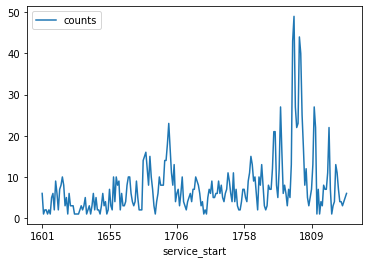

In [261]:
ships_over_time = ships.value_counts("service_start").rename_axis("service_start").reset_index(name="counts")
ships_over_time.sort_values("service_start", inplace=True)
ships_over_time.plot(kind="line", x="service_start", y="counts")

Of what type were the ships? See https://eicships.threedecks.org/help/shiprole.php for a more detailed explanation.

In [323]:
ships["ship_type"].replace({
    "Reg": "Regular ship",
    "ES": "Extra ship",
    "Int": "Interloper",
    "Lic": "Licensed ship",
    "NC": "New Company ship",
    "PS": "Packet service", 
    "Cha": "Chartered ship"
}, inplace = True)
ships.dropna().value_counts("ship_type")

ship_type
Regular ship        755
Extra ship          226
Chartered ship       64
New Company ship     34
Packet service       27
Licensed ship        22
Interloper            5
Cou                   2
Pil                   1
Re                    1
dtype: int64

Here, I attempted to calculate average service time of ships, but got stuck on combining the two existing columns due to problems with the data. I would also appreciate feedback here on whether there is a more efficient way to tackle this problem apart from manually cleaning the data, which currently seems to be the only real option to me.

In [304]:
ships["service_time"] = ships["service_end"].astype("int") - ships["service_start"].astype("int")

ValueError: invalid literal for int() with base 10: '1797; 1825                  '